In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
import numpy as np
import random
from tqdm import tqdm
from torchvision import transforms


############################
# 1. Reproducibility setup #
############################
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # make cuDNN deterministic (slightly slower, but stable)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

############################
# 2. Config / hyperparams  #
############################
TRAIN_DIR = r"C:/Users/ADMIN/Downloads/datasets/datasets/train"
VAL_DIR   = r"C:/Users/ADMIN/Downloads/datasets/datasets/val"

BATCH_SIZE     = 32
LR             = 1e-4          # learning rate, change from 1e-3 to 1e-4 cause smaller LR prevent damaging the pretrained imagenet weights
WEIGHT_DECAY   = 1e-4          # L2 regularization
EPOCHS         = 20
NUM_WORKERS    = 2
PIN_MEMORY     = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#####################################
# 3. Dataset & transforms (aug)    #
#####################################
weights = ResNet18_Weights.DEFAULT

imagenet_mean = weights.transforms().mean
imagenet_std  = weights.transforms().std

# --- Augmentations for training data ---
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),   # random zoom / crop
    transforms.RandomHorizontalFlip(p=0.5),                # left-right flip
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2),                # lighting changes
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean,
                         std=imagenet_std),
])

# --- Validation / evaluation transform (deterministic) ---
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean,
                         std=imagenet_std),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_transform)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

print("Classes:", train_ds.classes)
print("Train samples:", len(train_ds), "Val samples:", len(val_ds))

#####################################
# 4. Model: pretrained ResNet18     #
#####################################
model = resnet18(weights=weights)

# Replace final FC for 2 classes
num_feats = model.fc.in_features
model.fc = nn.Linear(num_feats, 2)

# 1) Freeze everything first
for param in model.parameters():
    param.requires_grad = False

# 2) Unfreeze last block (layer4) and the new head (fc)
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

#####################################
# 5. Loss, Optimizer, Scheduler     #
#####################################
criterion = nn.CrossEntropyLoss()

# Only optimize the new head (model.fc) since backbone is frozen
optimizer = optim.AdamW(
    model.fc.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

# Optional: if val accuracy plateaus, reduce LR
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=2,
    verbose=True
)

############################
# 6. Helper: accuracy      #
############################
def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    correct = (preds == targets).float().sum().item()
    total = targets.size(0)
    return correct / total

############################
# 7. Train / Eval loops    #
############################
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0
    running_acc  = 0.0
    n = 0

    for xb, yb in tqdm(loader, desc="Train", leave=False):
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        bs = yb.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy_from_logits(logits, yb) * bs
        n += bs

    return running_loss / n, running_acc / n

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    running_loss = 0.0
    running_acc  = 0.0
    n = 0

    for xb, yb in tqdm(loader, desc="Val  ", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        bs = yb.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy_from_logits(logits, yb) * bs
        n += bs

    return running_loss / n, running_acc / n

############################
# 8. Main training loop    #
############################
best_val_acc = 0.0

# Store history
train_losses, val_losses = [], []
train_accs, val_accs = [], []
lrs = []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    va_loss, va_acc = evaluate(model, val_loader)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:02d} | "
          f"Train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"Val loss {va_loss:.4f} acc {va_acc:.3f} | "
          f"LR {current_lr:.2e}")

    # Record metrics
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)
    lrs.append(current_lr)

    # Step LR scheduler with validation metric
    scheduler.step(va_acc)

    # Save best model
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), "resnet18_best_headonly.pt")
        print("  ✅ Saved best model")

print("Best Validation Accuracy:", best_val_acc)


C:\Users\ADMIN\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Classes: ['cat', 'dog']
Train samples: 20000 Val samples: 5000


Epoch 01 | Train loss 0.3214 acc 0.872 | Val loss 0.1510 acc 0.957 | LR 1.00e-04
  ✅ Saved best model


Epoch 02 | Train loss 0.1401 acc 0.957 | Val loss 0.0998 acc 0.971 | LR 1.00e-04
  ✅ Saved best model


Epoch 03 | Train loss 0.1135 acc 0.963 | Val loss 0.0801 acc 0.976 | LR 1.00e-04
  ✅ Saved best model


Epoch 04 | Train loss 0.0995 acc 0.965 | Val loss 0.0732 acc 0.977 | LR 1.00e-04
  ✅ Saved best model


Epoch 05 | Train loss 0.0971 acc 0.965 | Val loss 0.0687 acc 0.979 | LR 1.00e-04
  ✅ Saved best model


Epoch 06 | Train loss 0.0915 acc 0.965 | Val loss 0.0641 acc 0.980 | LR 1.00e-04
  ✅ Saved best model


Epoch 07 | Train loss 0.0880 acc 0.966 | Val loss 0.0630 acc 0.980 | LR 1.00e-04


Epoch 08 | Train loss 0.0831 acc 0.970 | Val loss 0.0566 acc 0.982 | LR 1.00e-04
  ✅ Saved best model


Epoch 09 | Train loss 0.0814 acc 0.969 | Val loss 0.0557 acc 0.982 | LR 1.00e-04


Epoch 10 | Train loss 0.0787 acc 0.970 | Val loss 0.0543 acc 0.982 | LR 1.00e-04


Epoch 11 | Train loss 0.0755 acc 0.971 | Val loss 0.0519 acc 0.982 | LR 1.00e-04


Epoch 12 | Train loss 0.0765 acc 0.970 | Val loss 0.0529 acc 0.982 | LR 5.00e-05


Epoch 13 | Train loss 0.0741 acc 0.971 | Val loss 0.0519 acc 0.983 | LR 5.00e-05
  ✅ Saved best model


Epoch 14 | Train loss 0.0771 acc 0.971 | Val loss 0.0538 acc 0.981 | LR 5.00e-05


Epoch 15 | Train loss 0.0740 acc 0.972 | Val loss 0.0526 acc 0.981 | LR 5.00e-05


Epoch 16 | Train loss 0.0721 acc 0.972 | Val loss 0.0502 acc 0.983 | LR 5.00e-05


Epoch 17 | Train loss 0.0750 acc 0.971 | Val loss 0.0496 acc 0.982 | LR 2.50e-05


Epoch 18 | Train loss 0.0738 acc 0.970 | Val loss 0.0527 acc 0.981 | LR 2.50e-05


Epoch 19 | Train loss 0.0707 acc 0.972 | Val loss 0.0507 acc 0.983 | LR 2.50e-05


Epoch 20 | Train loss 0.0749 acc 0.971 | Val loss 0.0499 acc 0.983 | LR 1.25e-05
  ✅ Saved best model
Best Validation Accuracy: 0.9832


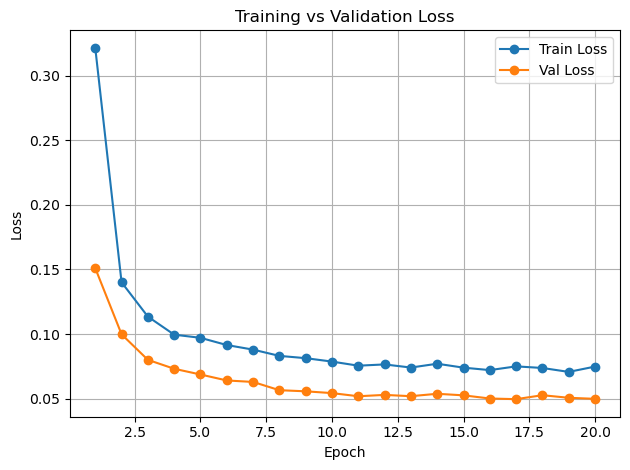

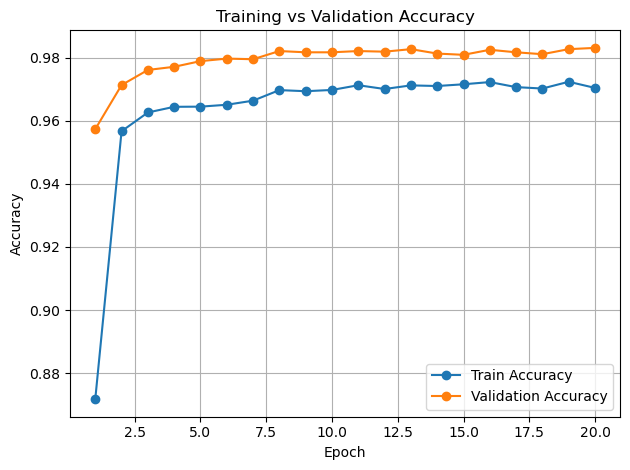

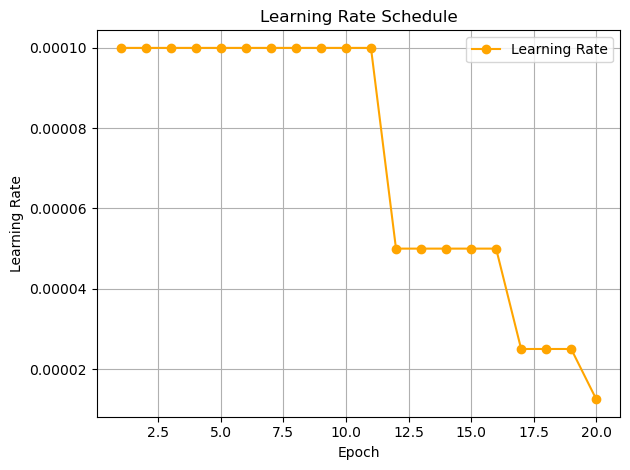

✅ Saved 'loss_curve2.png', 'accuracy_curve2.png', and 'lr_curve2.png' successfully.


In [9]:
##########################################
# 9. Plot and Save Training Curve Images #
##########################################
import matplotlib.pyplot as plt

# Create range of epoch numbers
epochs_range = range(1, EPOCHS + 1)

# === 1️⃣ Training vs Validation Loss ===
plt.figure()
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses, marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve2.png", dpi=300, bbox_inches='tight')
plt.show()

plt.close()   # close after saving to avoid overlap

# === 2️⃣ Training vs Validation Accuracy ===
plt.figure()
plt.plot(epochs_range, train_accs, marker='o', label='Train Accuracy')
plt.plot(epochs_range, val_accs, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_curve2.png", dpi=300, bbox_inches='tight')
plt.show()

plt.close()

# === 3️⃣ Learning Rate Schedule ===
plt.figure()
plt.plot(epochs_range, lrs, marker='o', color='orange', label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("lr_curve2.png", dpi=300, bbox_inches='tight')
plt.show()

plt.close()



print("✅ Saved 'loss_curve2.png', 'accuracy_curve2.png', and 'lr_curve2.png' successfully.")


In [4]:
#Testing

Preview of provided ground truth labels:


,image_id,true_id,filename
0,1,0,1.jpg
1,2,0,2.jpg
2,3,0,3.jpg
3,4,1,4.jpg
4,5,1,5.jpg


✅ Saved per-image predictions to test_predictions_resnett.csv
Sample predictions:


,filename,true_id,pred_id,true_name,pred_name,confidence
0,1.jpg,0,0,cat,cat,0.9799
1,2.jpg,0,0,cat,cat,0.9913
2,3.jpg,0,0,cat,cat,0.9998
3,4.jpg,1,1,dog,dog,0.9981
4,5.jpg,1,1,dog,dog,1.0000



🔢 Test Accuracy: 97.00%

📋 Classification Report:
              precision    recall  f1-score   support

      cat(0)     0.9558    0.9835    0.9695       242
      dog(1)     0.9841    0.9574    0.9705       258

    accuracy                         0.9700       500
   macro avg     0.9699    0.9704    0.9700       500
weighted avg     0.9704    0.9700    0.9700       500

Confusion matrix (raw counts):
 [[238   4]
 [ 11 247]]


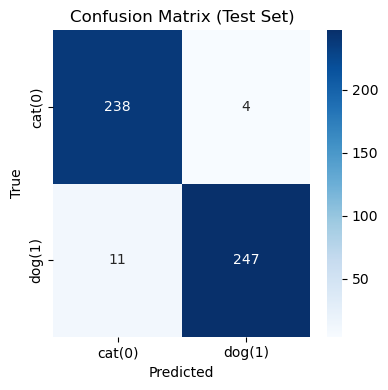

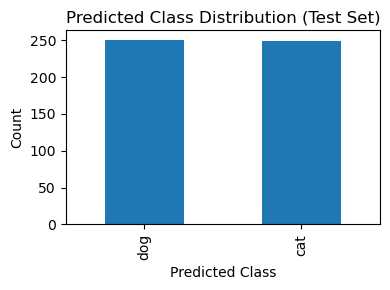

In [10]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

########################################
# 1. CONFIG / ASSUMPTIONS
########################################
# Folder with test images (no subfolders)
TEST_DIR = r"C:\Users\ADMIN\Downloads\datasets\datasets\test"

# CSV with manual ground truth labels for test images
# Expected format: [filename(without .jpg), true_id]
GT_CSV   = r"C:\Users\ADMIN\Downloads\datasets\datasets\testClassification.csv"

# Class index meaning used during TRAINING:
#   0 -> cat, 1 -> dog
CLASS_NAMES = ['cat', 'dog']

# Model + preprocess are assumed to ALREADY exist in the notebook from training:
#   - model : the trained ResNet18 with new fc layer
#   - preprocess : the same weights.transforms() you used for training/val
#   - device : "cuda" or "cpu"
model.eval()  # make sure model is in eval mode (turn off dropout, etc.)

########################################
# 2. LOAD GROUND TRUTH CSV
########################################
# Your CSV has two columns, no header:
#   col0 = image id (e.g. "123" for "123.jpg")
#   col1 = true label id (0 or 1)
gt = pd.read_csv(GT_CSV, header=None, names=['image_id', 'true_id'])

# Ensure filenames match actual files on disk
# If CSV already has ".jpg", you can skip this line
gt['filename'] = gt['image_id'].astype(str) + ".jpg"

# (Optional) sanity check
print("Preview of provided ground truth labels:")
display(gt.head())

########################################
# 3. RUN INFERENCE ON TEST IMAGES
########################################
records = []
missing_files = []

with torch.no_grad():
    for _, row in gt.iterrows():
        fname   = row['filename']
        true_id = int(row['true_id'])

        img_path = os.path.join(TEST_DIR, fname)

        # Skip if file missing
        if not os.path.exists(img_path):
            missing_files.append(fname)
            continue

        # Load + preprocess (same as training!)
        img = Image.open(img_path).convert("RGB")
        x   = preprocess(img).unsqueeze(0).to(device)  # [1,3,224,224]

        # Forward pass
        logits = model(x)                     # [1,2]
        probs  = torch.softmax(logits, dim=1) # [1,2]
        probs_np = probs.squeeze(0).cpu().numpy()

        pred_id = int(np.argmax(probs_np))
        conf    = float(np.max(probs_np))  # confidence of predicted class

        records.append({
            "filename": fname,
            "true_id": true_id,
            "pred_id": pred_id,
            "true_name": CLASS_NAMES[true_id] if true_id < len(CLASS_NAMES) else str(true_id),
            "pred_name": CLASS_NAMES[pred_id] if pred_id < len(CLASS_NAMES) else str(pred_id),
            "confidence": round(conf, 4),
        })

# Convert results to DataFrame
results_df = pd.DataFrame(records)

########################################
# 4. SAVE PREDICTIONS TO CSV (FOR REPORT / MARKER)
########################################
out_path = "test_predictions_resnett.csv"
results_df.to_csv(out_path, index=False)
print(f"✅ Saved per-image predictions to {out_path}")

# Show a small sample
print("Sample predictions:")
display(results_df.head())

# Warn if anything missing
if len(missing_files) > 0:
    print("⚠ These filenames were in CSV but not found on disk:")
    for mf in missing_files[:10]:
        print("  -", mf)
    if len(missing_files) > 10:
        print(f"  ... (+{len(missing_files)-10} more)")

########################################
# 5. METRICS: ACCURACY / REPORT / CONFUSION MATRIX
########################################
y_true = results_df["true_id"].to_numpy()
y_pred = results_df["pred_id"].to_numpy()

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n🔢 Test Accuracy: {acc*100:.2f}%")

# Detailed per-class precision / recall / F1
print("\n📋 Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=[f"{CLASS_NAMES[i]}({i})" for i in range(len(CLASS_NAMES))],
    digits=4
))

# Confusion Matrix (counts)
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (raw counts):\n", cm)

########################################
# 6. VISUALIZE CONFUSION MATRIX
########################################
plt.figure(figsize=(4,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[f"{CLASS_NAMES[i]}({i})" for i in range(len(CLASS_NAMES))],
    yticklabels=[f"{CLASS_NAMES[i]}({i})" for i in range(len(CLASS_NAMES))],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

########################################
# 7. VISUALIZE CLASS DISTRIBUTION OF PREDICTIONS
########################################
plt.figure(figsize=(4,3))
results_df['pred_name'].value_counts().plot(kind='bar')
plt.title('Predicted Class Distribution (Test Set)')
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [11]:
#View misclassified samples

Total test samples: 500
❌ Misclassified samples: 15
✅ Correctly classified samples: 485


,filename,true_id,pred_id,true_name,pred_name,confidence
15,16.jpg,0,1,cat,dog,0.6379
45,46.jpg,0,1,cat,dog,0.7097
46,47.jpg,1,0,dog,cat,0.5931
49,50.jpg,1,0,dog,cat,0.7368
82,83.jpg,0,1,cat,dog,0.9992
236,237.jpg,1,0,dog,cat,0.8071
243,244.jpg,1,0,dog,cat,0.9756
244,245.jpg,1,0,dog,cat,0.7695
260,261.jpg,1,0,dog,cat,0.5782
312,313.jpg,1,0,dog,cat,0.9368


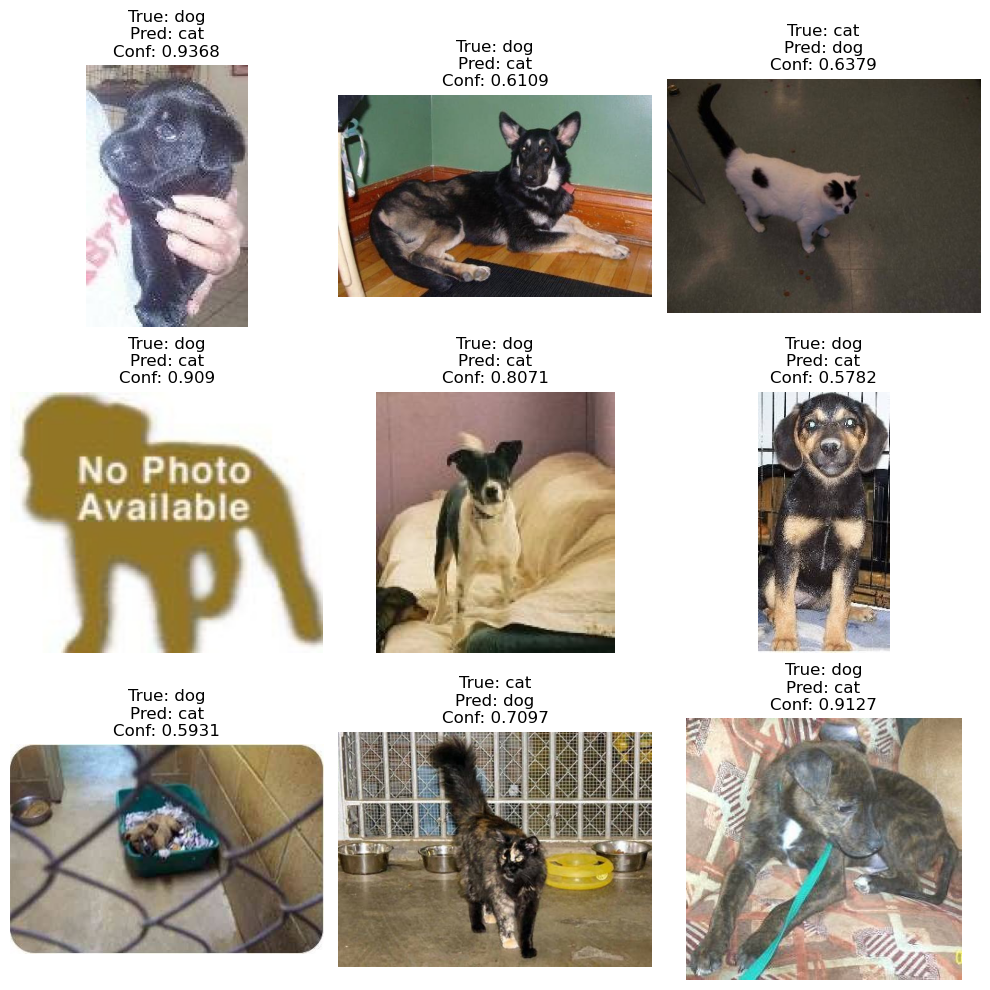

Top confusions:


,true_name,pred_name,count
1,dog,cat,11
0,cat,dog,4


In [14]:
from PIL import Image

# Filter out misclassified samples
misclassified_df = results_df[results_df["true_id"] != results_df["pred_id"]]

print(f"Total test samples: {len(results_df)}")
print(f"❌ Misclassified samples: {len(misclassified_df)}")
print(f"✅ Correctly classified samples: {len(results_df) - len(misclassified_df)}")

# Show a few examples
display(misclassified_df.head(10))


# Pick up to 9 misclassified images to visualize
samples_to_show = misclassified_df.sample(min(9, len(misclassified_df)), random_state=42)

plt.figure(figsize=(10, 10))
for i, row in enumerate(samples_to_show.itertuples(), 1):
    img_path = os.path.join(TEST_DIR, row.filename)
    img = Image.open(img_path).convert("RGB")
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {row.true_name}\nPred: {row.pred_name}\nConf: {row.confidence}")
plt.tight_layout()
plt.show()

error_summary = (
    misclassified_df.groupby(["true_name", "pred_name"])
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
)
print("Top confusions:")
display(error_summary)



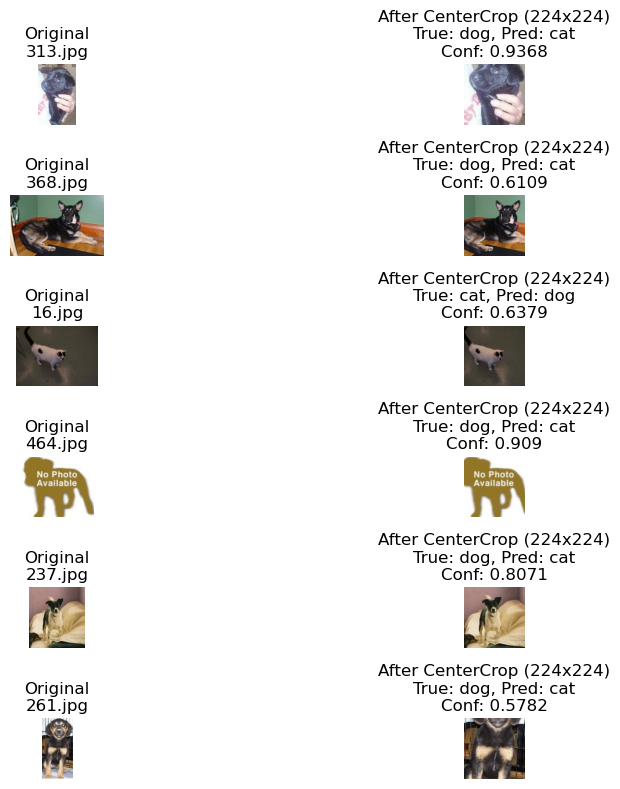

In [17]:
from torchvision import transforms

# Reuse same preprocessing (weights.transforms()) that was used during training
# It usually includes Resize(256) → CenterCrop(224) → ToTensor() → Normalize(...)
# We'll remove normalization temporarily just for display.

# Extract only the geometric transforms (no normalization) for visualization
display_transform = transforms.Compose([
    transforms.Resize(preprocess.crop_size),     # match the crop size
    transforms.CenterCrop(preprocess.crop_size),
])

# Pick up to 6 misclassified images to visualize (side-by-side: original vs cropped)
samples_to_show = misclassified_df.sample(min(6, len(misclassified_df)), random_state=42)

plt.figure(figsize=(12, 8))
for i, row in enumerate(samples_to_show.itertuples(), 1):
    img_path = os.path.join(TEST_DIR, row.filename)
    img = Image.open(img_path).convert("RGB")

    # Apply same crop transform (without normalization) for visualization
    cropped_img = display_transform(img)

    # --- left: original ---
    plt.subplot(len(samples_to_show), 2, 2*i - 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Original\n{row.filename}")

    # --- right: preprocessed view ---
    plt.subplot(len(samples_to_show), 2, 2*i)
    plt.imshow(cropped_img)
    plt.axis("off")
    plt.title(f"After CenterCrop (224x224)\nTrue: {row.true_name}, Pred: {row.pred_name}\nConf: {row.confidence}")

plt.tight_layout()
plt.show()